# A practical insight on Gaia (EDR3) distances

*Gaia* is a survey mission targeted to astrometry (as well as photometry and spectroscopy!) in the optical band and covers the entire sky. Arguably the most interesting thing for us is that it can measure distances to stars. Well, not quite. What Gaia measures (among other things) is parallax $w$, and $d=1/w$, which leads to some problems. As for most observables, uncertainty for parallax is ~gaussian, so inversion is tricky. Imagine, for instance, that you measure parallax of $w=0.1(1)$ mas, what your distance and uncertainty will be? The answer is not trivial, actually, and depends on many details of instrument's operation, location and properties of the source, etc. The *Gaia* collaboration obviously realizes that and does it best to adresss this issue. The current state of the art is series of papers by Bailer-Jones, the links appropriate for Gaia EDR3 are summarized [here](https://www2.mpia-hd.mpg.de/homes/calj/gedr3_distances/main.html). 

The main idea is that probability that a source is actually at the given distance is a product of probability given by parallax inversion and probability to observe your star by Gaia in a given direction at a given distance. It's not trivial to derive either, so I'll just urge you to read the Bailer-Jones paper. Since it's a data analysis meeting, I'll not repeat any of the formulas from there or cited papers, but would like just to illustrate how you could get distance estimate and posterior probabilities for a given source in practice. This requires some querying of relevant databases. First, we need to get parallax and some basic information about source of interest. The later is needed to derive so-called zero point, i.e. systematic offset in parallax present in Gaia measurements for our source (see i.e. [preprint](https://arxiv.org/abs/2012.01742) for detail). In practice, *Gaia* does provide python module to calculate that (plus some other useful codes) at their [codes webpage](https://www.cosmos.esa.int/web/gaia/edr3-code).

In [6]:
from astroquery.gaia import Gaia
import astropy.units as u
import astropy.coordinates
from numpy import *
import pylab as pl

# let's define some source, for instance, Her X-1
coord = astropy.coordinates.get_icrs_coordinates('Her X-1')

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"
data = Gaia.query_object_async(coordinate=coord,width=1*u.arcsec,height=1*u.arcsec) 
# from https://gitlab.com/icc-ub/public/gaiadr3_zeropoint/-/blob/master/tutorial/ZeroPoint_examples.ipynb
gmag = data['phot_g_mean_mag'].data.data[0]
nueffused = data['nu_eff_used_in_astrometry'].data.data[0]
psc = data['pseudocolour'].data.data[0]
ecl_lat = data['ecl_lat'].data.data[0]
soltype = data['astrometric_params_solved'].data.data[0]
from zero_point import zpt
zpt.load_tables()
zpvals = zpt.get_zpt(gmag, nueffused, psc, ecl_lat, soltype)
px = data['parallax'].data.data[0]
pxe = data['parallax_error'].data.data[0]


INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
print(px,pxe,zpvals)

0.1152951451841277 0.013840411 -0.026131


Now we can calculate/plot probability to observe source from given distance using Eq. 2 from [Bailer-Jones 2021](https://www2.mpia-hd.mpg.de/homes/calj/gedr3_distances/gedr3_distances.pdf). Note that it's not normalized

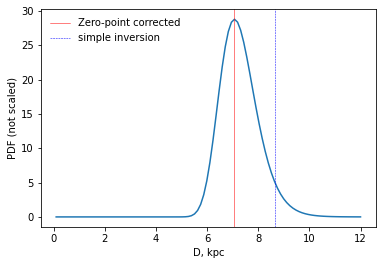

In [19]:
def edr3_pxprob(r,px=px,pxe=pxe,wzp=zpvals):
    """Parallax and parallax error are set to what we obtained above"""
    return 1./(sqrt(2*pi)*pxe)*exp(-0.5/pxe**2*(px-wzp-1/r)**2)

r = linspace(0.1,12,100)
pl.plot(r,edr3_pxprob(r))
pl.xlabel('D, kpc')
pl.ylabel('PDF (not scaled)')
pl.axvline(1./(px-zpvals), c='r',lw=0.5,label='Zero-point corrected')
pl.axvline(1./px, c='b',ls='dashed',lw=0.5,label='simple inversion')
pl.legend(frameon=False)

This works reasonably well if the parallax uncertainty is relatively small, however, if that's not the case we need to take into account also the geometric prior (i.e. probability that Gaia can observe star with given magnitude in given direction). That's actually what Bailed-Jones paper is mostly about. They do provide parametrization for this which is given by:

In [20]:
def edr3_geoprior(r, alpha,beta, L):
    """parameters set for our healpix. Using info https://www2.mpia-hd.mpg.de/homes/calj/gedr3_distances/main.html"""
    from scipy.special import gamma
    return alpha/gamma((beta+1)/alpha)/(L**(beta+1))*(r*1000)**beta*exp(-((r*1000)/L)**alpha)


but the problem is that $\alpha$, $\beta$ and $L$ depend on position on the sky and sources which are actually observed there. The information about these parameters (which is a result of MCMC fitting they do) is available in a cvs file hosted [here](https://keeper.mpdl.mpg.de/d/0e9919daa8fa4e119ebe/files/?p=%2Fprior_summary.csv). I'm using a local copy

In [29]:
data = loadtxt('prior_summary.csv',skiprows=1,unpack=True,delimiter=',')
# The parameters are reported per healpix pixel on the sky. This includes also Galactic coordinates for each pixel
# We read those to find row number we need to read other parameters from
l, b = data[1],data[2]
gci = astropy.coordinates.SkyCoord(l,b,frame='galactic',unit=u.deg)
ii = argmin(gci.separation(coord))
alpha, beta, L = [data[x][ii] for x in [6,7,5]]
print(alpha,beta,L)

0.219517044266944 4.57703045227438 0.000607041958667564


Now we can also plot geometric prior for our source

Text(0, 0.5, 'Geometric prior')

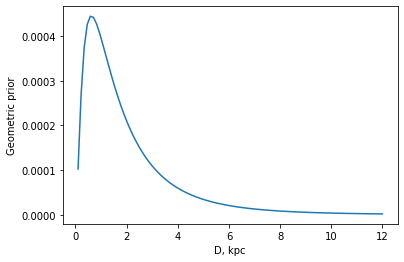

In [35]:
pl.plot(r,edr3_geoprior(r,alpha=alpha,beta=beta,L=L))
pl.xlabel('D, kpc')
pl.ylabel('Geometric prior')

This basically tells us that most of the sources in the direction of Her X-1 are observed at around 1 kpc distance. Now we can combine the two estimates. But before doing so we need to normalize both PDFs. I'm sure there's an analytic option, but I do this numerically for simplicity. Then I mulitply one by another to get total probability, and then again normalize that to yield proper PDF. Below I also illustrate impact of taking geometric prior into the account.

Text(0, 0.5, 'PDF')

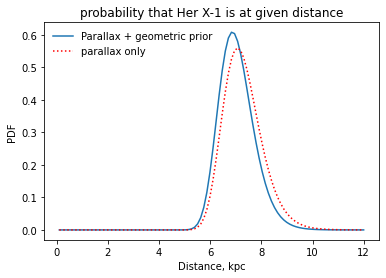

In [56]:
import scipy.integrate
intgeo = scipy.integrate.quad(lambda r: edr3_geoprior(r,alpha=alpha,beta=beta,L=L),0,50)[0]
intpx = scipy.integrate.quad(edr3_pxprob,0,50)[0]
total_prob = lambda r: (edr3_geoprior(r,alpha=alpha,beta=beta,L=L)/intgeo)*(edr3_pxprob(r)/intpx)
inttot = scipy.integrate.quad(total_prob,0,50)[0]
total_pdf = lambda r: total_prob(r)/inttot
pl.plot(r,total_pdf(r),label='Parallax + geometric prior')
pl.plot(r,edr3_pxprob(r)/intpx,ls='dotted',c='r',label='parallax only')
pl.legend(frameon=False)
pl.title('probability that Her X-1 is at given distance')
pl.xlabel('Distance, kpc')
pl.ylabel('PDF')

Obviously, you can also now apply some descriptive statistics to get some numbers. Note that here you're interested in cumulative probability, i.e. we need to integrate PDF. With this done, we can compare result with what's reported in Bailer-Jones catalogue (or do more sophisticated stuff). Here I plot our 16/84/50% quantiles derived from CDF as horizontal lines and what's reported in the catalog as vertical lines. Note that there's some (minor) discrepancy because values reported in the catalog are derived directly from MCMC samples whereas we use analytical approximation. 

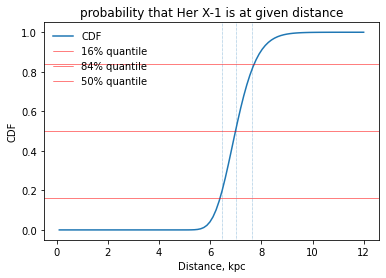

In [59]:
pl.title('probability that Her X-1 is at given distance')
pl.xlabel('Distance, kpc')
pl.ylabel('CDF')
cumprob = array([scipy.integrate.quad(total_pdf,0,x)[0] for x in r])
pl.plot(r,cumprob,label='CDF')
pl.axhline(0.16,c='r',lw=0.5,label='16% quantile')
pl.axhline(0.84,c='r',lw=0.5,label='84% quantile')
pl.axhline(0.5,c='r',lw=0.5,label='50% quantile')
pl.legend(frameon=False)
# values from the catalog, see i.e. https://dc.zah.uni-heidelberg.de/gedr3dist/q/cone/form 
[pl.axvline(x/1000,lw=0.5,ls='dotted') for x in [7004.812,6461.383,7648.648]]

Of course, you can just get distances from the catalog (including also "photo-geometric" distances, which is another level of complication!). The excercise above is mostly to better understand what Gaia distances really are, and get a taste of complications involved. That said, it can still be useful for practical applications, i.e. for instance if you'd like to derive your own "photo-geometric" distance, or consider just Gaia parallaxes for some application. For instance, you could get a more realistic luminosity estimate given observed flux, or as a prior for your own MCMC analysis. For that you'd often need to invert CDF, i.e. to get expected distance given some probability. The easiest way is just to use interpolation for lookup:

In [73]:
import scipy.interpolate
cumprob[-1]=1
ci = scipy.interpolate.interp1d(cumprob,r)

Now you can use that for sampling (i.e. as prior for MCMC packages), or just make a histogram of expected distances. To do that, you can just sample probabilities uniformly from 0-1 interval and lookup corresponding distance using our interpolator. That's a standard way to generate random numbers given CDF called [Inverse trasform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling). That's how most MCMC packages define their priors.

Text(0, 0.5, 'Samples')

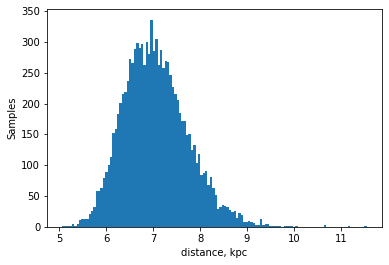

In [75]:
junk = pl.hist(ci(random.uniform(0,1,size=10000)),128)
pl.xlabel('distance, kpc')
pl.ylabel('Samples')

Obviously, you can also transform that to luminosities and get estimate of luminosity and its uncertainty. For instance, imaginge that your observed flux is $10^{-8}$ erg/cm2/s:

Luminosity (only considering uncertainty in distance) is $L=8.37_{-0.73}^{+0.88}\times10^{37}$ erg/s


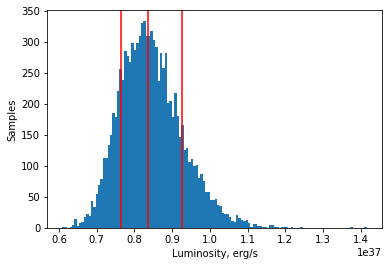

In [88]:
samples = 1e-8*4*pi*(3.086e21)**2*ci(random.uniform(0,1,size=10000))
junk = pl.hist(samples,128)
pl.xlabel('Luminosity, erg/s')
pl.ylabel('Samples')
pl.axvline(percentile(samples,16),c='r')
pl.axvline(percentile(samples,84),c='r')
pl.axvline(percentile(samples,50),c='r')
print(r"Luminosity (only considering uncertainty in distance) is $L=%.2f_{-%.2f}^{+%.2f}\times10^{37}$ erg/s"%(percentile(samples,50)/1e36,(percentile(samples,50)-percentile(samples,16))/1e36,(percentile(samples,84)-percentile(samples,50))/1e36))

Again, in this particular case assymetry of error bars is not important, but if you have a source with a worse parallax, it might be a problem.